# VOLATILITY IN STOCK MARKET INDICES
## Introduction to Programming and Numerical Analysis - Spring 2020 - Project 1: Data analysis

In this project we fetch daily data for the Nasdaq Composite, Nikkei 225 and OMX C20 indices and use them to perform a descriptive analysis of stock market volatility from 2000 to today. Volatility is important for investors as it is related to the risk of holding assets. First, we read in and clean the data. Next, we use the concatenate and join functions to compile the data in a single DataFrame. Then, we compute log returns and analyse these through descriptive statistics and (interactive) visualisations. Finally, we account for some real world events, which can be drivers of increased volatility in given periods. 

**Team:** Kongerækken

**Members:** Frederik Degn Pedersen (qwn116) & Christian Brauer Johanssen (sjk185)

**Imports and set magics:**

In [24]:
import numpy as np
import pandas as pd
import pandas_datareader
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2 # install with pip install matplotlib-venn
plt.style.use('seaborn-whitegrid')

import pydst #install with pip install pydst
import datetime
import quandl #install with pip install quandl

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# we do not use any local modules

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data for stock market indices
In this section, we first import data for the Nasdaq Composite and Nikkei 225 indices using the FRED API, and OMX C20 data using the Qandl API. We use Nasdaq Composite instead of the more broad S&P 500 index because it was easier to obtain a time series all the way back to 2000 for the former. Because the Quandl time series only stretches back to late 2008 (when Nasdaq aqcuired Københavns Fondsbørs), we complement the series with additional data from Statistics Denmark. Ultimately, we clean and merge the datasets into a single DataFrame to be used for later analysis.

## FRED Data

In [25]:
# set start and end dates
start = datetime.datetime(2000,1,1)
end = datetime.datetime(2020,4,6) #make more recent?

# read in data
stock_indices = pandas_datareader.data.DataReader(['NASDAQCOM', 'NIKKEI225'], 'fred', start, end)

# reset index
stock_indices.reset_index(inplace=True)

# rename columns
stock_indices.rename(columns = {'DATE':'date','NASDAQCOM':'nasdaq','NIKKEI225':'nikkei'}, inplace=True)

# show head
stock_indices.head()

,date,nasdaq,nikkei
0,2000-01-03,4131.15,NaN
1,2000-01-04,3901.69,19002.86
2,2000-01-05,3877.54,18542.55
3,2000-01-06,3727.13,18168.27
4,2000-01-07,3882.62,18193.41


In [26]:
# show info
stock_indices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5286 entries, 0 to 5285
Data columns (total 3 columns):
date      5286 non-null datetime64[ns]
nasdaq    5098 non-null float64
nikkei    4966 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 124.0 KB


## Statistics Denmark Data
Our variable of interest, namely daily observations of the OMX C20 index is available from the table "RENTD".

In [27]:
# setup data loader in english
Dst = pydst.Dst(lang='en') 

# read in data, see appendix for details
c20_dst = Dst.get_data(table_id = 'DNRENTD', variables={'INSTRUMENT':['CKXNAA'], 'LAND':['DK'],
                                                        'OPGOER':['I'], 'TID':['*']})

# show head
c20_dst.head()

,INSTRUMENT,LAND,OPGOER,TID,INDHOLD
0,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1985M11D08,..
1,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1985M11D11,..
2,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1986M06D02,..
3,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1986M06D03,..
4,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1986M06D04,..


In [28]:
# rename column
c20_dst.rename(columns = {'INDHOLD':'omx_c20'}, inplace=True)

# fix date format
c20_dst['date'] = c20_dst.TID.str[:4]+'-'+c20_dst.TID.str[5:7]+'-'+c20_dst.TID.str[-2:]
c20_dst['date'] = pd.to_datetime(c20_dst['date'])

# sort by 'date'
c20_dst = c20_dst.sort_values(['date'])

# drop missing values and reset index
c20_dst = c20_dst[c20_dst['omx_c20'] != '..']
c20_dst.reset_index(inplace=True)
c20_dst.head()

,index,INSTRUMENT,LAND,OPGOER,TID,omx_c20,date
0,7911,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D03,109.1900,1994-01-03
1,657,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D04,109.8500,1994-01-04
2,658,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D05,110.1700,1994-01-05
3,659,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D06,109.7900,1994-01-06
4,660,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D07,109.0600,1994-01-07


In [29]:
# drop irrelevant columns
drop_these = ['index', 'INSTRUMENT', 'LAND', 'OPGOER', 'index','TID']
c20_dst.drop(drop_these, axis=1, inplace=True)

#order columns
cols = ['date']  + [col for col in c20_dst if col != 'date']
c20_dst = c20_dst[cols]

# change type to float
c20_dst['omx_c20'] = pd.to_numeric(c20_dst['omx_c20'], errors='coerce')

# drop dates before y2k
# a) find 
c20_dst.loc[c20_dst['date'] == '1999-12-31'] # index is 1509

# b) slice index of last trading day before y2k
c20_dst = c20_dst.iloc[1510:]

In [30]:
# show DataFrame
c20_dst

,date,omx_c20
1510,2000-01-03,260.92
1511,2000-01-04,252.78
1512,2000-01-05,246.98
1513,2000-01-06,249.47
1514,2000-01-07,251.79
...,...,...
4744,2012-11-26,487.22
4745,2012-11-27,488.88
4746,2012-11-28,486.44
4747,2012-11-29,490.77


In [31]:
# show info
c20_dst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 1510 to 4748
Data columns (total 2 columns):
date       3239 non-null datetime64[ns]
omx_c20    3239 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 50.7 KB


## Quandl Data

In [32]:
# fetching c20 data from quandl
c20_qua = quandl.get('NASDAQOMX/OMXC20')

# drop irrelevant variables
drop_them = ['High', 'Low', 'Total Market Value', 'Dividend Market Value']
c20_qua.drop(drop_them,axis=1,inplace=True)

# reset index and rename columns
c20_qua.reset_index(inplace=True)
c20_qua.rename(columns={'Index Value':'omx_c20','Trade Date':'date'},inplace=True)

# show DataFrame
c20_qua

,date,omx_c20
0,2008-11-17,262.89
1,2008-11-18,259.09
2,2008-11-19,249.53
3,2008-11-20,236.79
4,2008-11-24,245.91
...,...,...
2842,2020-05-11,1187.63
2843,2020-05-12,1187.71
2844,2020-05-13,1184.87
2845,2020-05-14,1174.33


In [33]:
# show info
c20_qua.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2847 entries, 0 to 2846
Data columns (total 2 columns):
date       2847 non-null datetime64[ns]
omx_c20    2843 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 44.6 KB


# Merge datasets into single DataFrame
First we drop observations post 2008-11-16 in the DataFrame from Statistics Denmark to make sure we have no overlapping entries. Then, we concatenate the data Statistics Denmark and Quandl. Finally, we merge the C20 data onto the stock_indices DataFrame using an outer join. We also provide a Venn diagram to illustrate the outer join proces.

In [34]:
# drop dst obs. post 2008-11-16
# a) find 
c20_dst.loc[c20_dst['date'] == '2008-11-17'] # index is 3738

# b) slice index
c20_dst = c20_dst.iloc[:3738-1510]

# concatenate Quandl and Statistics Denmark data
c20 = pd.concat([c20_dst,c20_qua])
c20

,date,omx_c20
1510,2000-01-03,260.92
1511,2000-01-04,252.78
1512,2000-01-05,246.98
1513,2000-01-06,249.47
1514,2000-01-07,251.79
...,...,...
2842,2020-05-11,1187.63
2843,2020-05-12,1187.71
2844,2020-05-13,1184.87
2845,2020-05-14,1174.33


In [35]:
# show info
c20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5075 entries, 1510 to 2846
Data columns (total 2 columns):
date       5075 non-null datetime64[ns]
omx_c20    5071 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.9 KB


In [36]:
# merge c20 data onto fred data using outer join
stock_indices = pd.merge(stock_indices,c20,on=['date'],how='outer')

# drop nans
stock_indices.dropna(subset=['nasdaq','nikkei','omx_c20'],how='all',inplace=True)

#show DataFrame
stock_indices

,date,nasdaq,nikkei,omx_c20
0,2000-01-03,4131.15,NaN,260.92
1,2000-01-04,3901.69,19002.86,252.78
2,2000-01-05,3877.54,18542.55,246.98
3,2000-01-06,3727.13,18168.27,249.47
4,2000-01-07,3882.62,18193.41,251.79
...,...,...,...,...
5305,2020-05-07,NaN,NaN,1170.32
5306,2020-05-11,NaN,NaN,1187.63
5307,2020-05-12,NaN,NaN,1187.71
5308,2020-05-13,NaN,NaN,1184.87


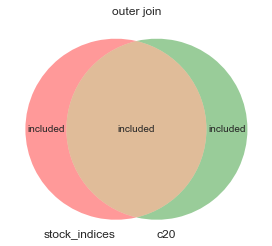

In [37]:
# venn diagram
plt.figure()
v = venn2(subsets = (4, 4, 10), set_labels = ('stock_indices', 'c20'))
v.get_label_by_id('100').set_text('included')
v.get_label_by_id('010').set_text('included')
v.get_label_by_id('110').set_text('included')
plt.title('outer join')
plt.show()

# Analysis
To get a feeling of the data at hand, we begin by graphing the raw indices.

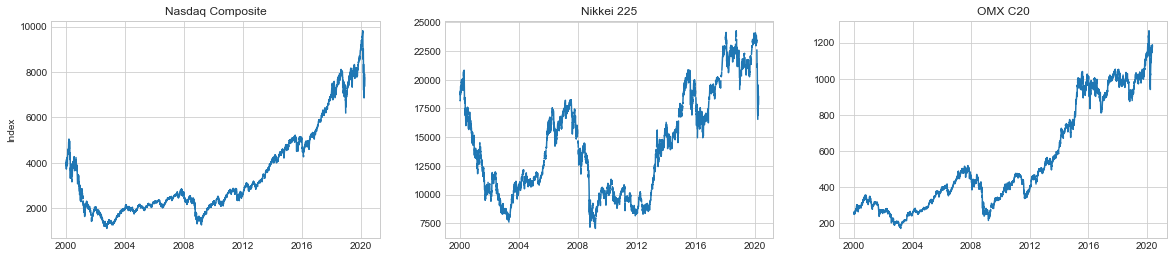

In [38]:
# graph raw indices 
fig_ind = plt.figure(figsize=(20,4))

ax_left = fig_ind.add_subplot(1,3,1)

ax_left.plot(stock_indices.date,stock_indices.nasdaq)
ax_left.set_title('Nasdaq Composite')
ax_left.set_ylabel('Index')
ax_left.grid(True)

ax_mid = fig_ind.add_subplot(1,3,2)

ax_mid.plot(stock_indices.date,stock_indices.nikkei)
ax_mid.set_title('Nikkei 225')
ax_mid.grid(True)
            
ax_right = fig_ind.add_subplot(1,3,3)

ax_right.plot(stock_indices.date,stock_indices.omx_c20)
ax_right.set_title('OMX C20')
ax_right.grid(True)

## Log Returns and Summary Statistics
Because the indices are not normalised (different base year, not necessarily indexed to 100 in the baseyear, ect.), it is not straightforward to make comparisons between them. Therefore, we calculate the log returns, $y_t$, as follows:

$$ y_t = 100(\ln{Y_{it}}-\ln{Y_{it-1}}),$$
where $Y_{it}$ denotes the value of index $i$ at time $t$.

The log returns are (approximately) equal to the daily return in percent. As we now measure the ***relative returns***, comparisons across indices are now possible. Thus we compute the mean return, the standard deviation, and the min and max observations for each index in each year (and for the same month in different years).

In [39]:
#calculate log returns
indices = ['nasdaq','nikkei', 'omx_c20']
for i in indices:
    stock_indices[f'log_returns_{i}'] = np.log(stock_indices[i]).diff()*100

In [40]:
# DataFrames with descriptive stats by year and month

#  extract year/month variable from datetime variable for statistics
stock_indices['year'], stock_indices['month'] = stock_indices['date'].dt.year, stock_indices['date'].dt.month

# setup empty DataFrame
desc_stat_y = pd.DataFrame()
desc_stat_m = pd.DataFrame()

# append columns to desc_stat
for i in indices:
    desc_stat_y[f'mean_{i}']= stock_indices.groupby('year')[f'log_returns_{i}'].mean()
    desc_stat_y[f'std_{i}'] = stock_indices.groupby('year')[f'log_returns_{i}'].std()
    desc_stat_y[f'min_{i}'] = stock_indices.groupby('year')[f'log_returns_{i}'].min()
    desc_stat_y[f'max_{i}'] = stock_indices.groupby('year')[f'log_returns_{i}'].max()

for i in indices:
    desc_stat_m[f'mean_{i}']= stock_indices.groupby('month')[f'log_returns_{i}'].mean()
    desc_stat_m[f'std_{i}'] = stock_indices.groupby('month')[f'log_returns_{i}'].std()
    desc_stat_m[f'min_{i}'] = stock_indices.groupby('month')[f'log_returns_{i}'].min()
    desc_stat_m[f'max_{i}'] = stock_indices.groupby('month')[f'log_returns_{i}'].max()
    
desc_stat_y

,mean_nasdaq,std_nasdaq,min_nasdaq,max_nasdaq,mean_nikkei,std_nikkei,min_nikkei,max_nikkei,mean_omx_c20,std_omx_c20,min_omx_c20,max_omx_c20
year,,,,,,,,,,,,
2000,-0.223634,3.040178,-10.168411,9.963643,-0.144391,1.413980,-7.233984,3.688680,0.058271,1.371281,-4.655913,3.385079
2001,-0.013233,2.701096,-7.506494,13.254645,-0.145368,1.778012,-6.864457,4.785591,-0.072025,1.267232,-3.944924,3.315674
2002,-0.133510,2.146071,-4.268674,7.493773,-0.121180,1.584970,-4.104463,5.735232,-0.128802,1.556101,-5.592228,4.969850
2003,0.123313,1.379471,-3.730166,4.697792,0.010400,1.429745,-5.225837,3.325562,0.083936,1.136722,-3.266704,3.643380
2004,0.037141,1.069238,-2.552371,2.976501,0.049882,1.128903,-4.965470,2.764005,0.057384,0.757428,-3.451160,2.105019
2005,0.003338,0.784713,-2.079413,2.510342,0.096282,0.837941,-3.875580,2.206586,0.112608,0.830818,-2.834565,2.717106
2006,0.051367,0.880156,-2.378830,2.918396,0.044059,1.249234,-4.230414,3.522034,0.063378,0.966379,-4.165079,2.562359
2007,0.020586,1.108111,-3.935871,3.405569,-0.084207,1.163116,-5.569546,3.603123,0.020214,1.119626,-4.392061,3.745180
2008,-0.215815,2.607311,-9.587690,11.159442,-0.309722,2.787552,-12.111026,9.494147,-0.297121,2.439898,-11.723193,9.496355


In [41]:
desc_stat_m

,mean_nasdaq,std_nasdaq,min_nasdaq,max_nasdaq,mean_nikkei,std_nikkei,min_nikkei,max_nikkei,mean_omx_c20,std_omx_c20,min_omx_c20,max_omx_c20
month,,,,,,,,,,,,
1,0.038233,1.673455,-7.506494,13.254645,-0.073334,1.443609,-5.815688,5.710406,0.051376,1.175033,-5.575847,5.697046
2,-0.012927,1.353052,-5.124567,3.825103,0.000016,1.394205,-5.555174,6.911311,0.096920,1.310499,-6.780968,5.142810
3,0.004513,1.976347,-13.149032,8.934618,-0.032959,1.783731,-11.153434,7.731370,-0.011167,1.291417,-7.820803,4.875738
4,0.075735,1.824024,-10.168411,8.545415,0.049803,1.363624,-7.233984,4.310375,0.089555,1.282318,-4.655913,5.111416
5,-0.027414,1.435013,-6.118230,7.493773,-0.059539,1.286393,-7.597361,2.982411,0.050069,1.126074,-4.228675,6.167653
6,0.020429,1.333921,-4.202315,6.245505,0.020657,1.388982,-8.252932,4.825705,-0.046697,1.185761,-3.809050,3.309100
7,0.035951,1.363109,-4.777044,5.632569,-0.032107,1.196500,-3.472313,3.906545,0.084921,1.099921,-5.592228,4.969850
8,0.002335,1.423538,-7.148909,5.159185,-0.057086,1.316271,-5.569546,3.765184,0.021409,1.263712,-4.951225,3.745180
9,-0.064414,1.454373,-9.587690,5.216420,-0.018757,1.481745,-6.864457,7.426170,-0.092450,1.292159,-5.448375,6.591694


## Summary Statistics Plots
While the above DataFrames are good for looking up an exact value in a given year or month, it is not a good tool for comparison across stock markets or time. Therefore we provide an interactive plot below, where up to three statistics can be selected and compared. For instance, one can compare the standard deviations of the three different indices to get an indication of volatility in given years but also across time.

In [42]:
# setup
df = desc_stat_y # auxilliary DataFrame
df['years'] = df.index.values # get years for plotting
col_list = list(desc_stat_y.columns) # get input for dropdowns

# create plot function
def update_plot(stat1,stat2,stat3):
    """
    This function is linked to ipy.widgets dropdowns and it replots the figure
    for the chosen descriptive statistics.
    
    """
    
    df.plot('years',[stat1,stat2,stat3],style='-o',figsize=(14,6),xticks=[2000+i for i in range(0,21)]);
    #xticks used to avoid x axis ticks like 2007.5

# create dropdown widgets and interact
stat1 = widgets.Dropdown(description='Statistic #1',options=col_list)
stat2 = widgets.Dropdown(description='Statistic #2',options=col_list)
stat3 = widgets.Dropdown(description='Statistic #3',options=col_list)
                           
widgets.interact(update_plot,stat1=stat1,stat2=stat2,stat3=stat3);

interactive(children=(Dropdown(description='Statistic #1', options=('mean_nasdaq', 'std_nasdaq', 'min_nasdaq',…

## Volatility Plots
Another, and perhaps more granular, way to get a visual impression of the volatility across time is to plot the log returns directly, which we do below.

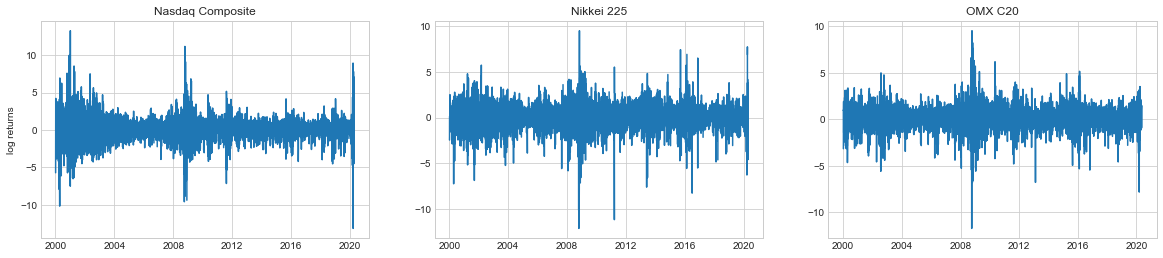

In [43]:
# create the figure
fig_vol = plt.figure(figsize=(20,4))

ax_left = fig_vol.add_subplot(1,3,1)

ax_left.plot(stock_indices.date,stock_indices.log_returns_nasdaq)
ax_left.set_title('Nasdaq Composite')
ax_left.set_ylabel('log returns')
ax_left.grid(True)

ax_mid = fig_vol.add_subplot(1,3,2)

ax_mid.plot(stock_indices.date,stock_indices.log_returns_nikkei)
ax_mid.set_title('Nikkei 225')
ax_mid.grid(True)
            
ax_right = fig_vol.add_subplot(1,3,3)

ax_right.plot(stock_indices.date,stock_indices.log_returns_omx_c20)
ax_right.set_title('OMX C20')
ax_right.grid(True)

Inspecting the log returns, three particular periods of high volatility stand out. First, in the beginning of our sample, the technology heavy Nasdaq index features very high volatility, which is likely to be related to the dotcom bubble from the start of the millenium. The same effect is traceable, although to a lesser extent in the Nikkei and OMX C20 indices. Second, all indices show high volatility in and around 2009, corresponding to the Global Financial Crisis. Here, the impact is reversed in the sense that Nikkei 225 and OMX C20 display a higher risk than Nasdaq. Ultimately, the corona crisis of the first quarter of 2020 spikes the volatility of all three indices, however once again Nasdaq appears to be most severely hit.

# Conclusion
In this project we use daily close prices from three selected stock indices to analyse and compare risk and return in the period 2000-2020Q1. First, we clean and merge the data into a single DataFrame, and then we use descriptive statistics and visualisations to perform the analysis. Generally, we find that the yearly standard deviations of return seems to be highly correlated across the three indices, which corresponds well to the observation of volatility clustering in three distinct time periods related to economic shocks of global scope.

# Appendix - Finding the Right Key for Statistics Denmark's RENTD Table
To find the dictionary input for data extraction from Statistics Denmark, we first use the get_variables command to inspect the variables.
To find the correct key for the OMX C20 data, we print the full string entered in the 'values' column and 'INSTRUMENT' row.

In [44]:
# inspect variables of DNRENTD
omx_info = Dst.get_variables(table_id='DNRENTD')
omx_info

,id,text,elimination,time,values
0,INSTRUMENT,item,False,False,"[{'id': 'ODKNAA', 'text': 'The Nationalbanks o..."
1,LAND,country,True,False,"[{'id': 'DK', 'text': 'DK: Denmark'}]"
2,OPGOER,methodology,False,False,"[{'id': 'E', 'text': 'Daily interest rates (pe..."
3,Tid,time,False,True,"[{'id': '1983M05D10', 'text': '1983M05D10'}, {..."


In [45]:
# Print full string to find the key for OMX C20
def print_full(x):
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.max_colwidth')

x = omx_info.loc[omx_info['id'] == 'INSTRUMENT'], ['values']
print_full(x)

(           id  text  elimination   time  \
0  INSTRUMENT  item  False        False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Alternatively (and much more neatly), we can **simply search** for 'OMXC20' in the keys and values of all the dictionary entries in the DataFrame omx_info

In [46]:
#search for 'OMXC20' in omx_info
print([entry for entry in omx_info.loc[0,'values'] if list(filter(lambda x: 'OMXC20' in x, entry.values()))])
print('Thus, the key needed in the API is CKXNAA')

[{'id': 'CKXNAA', 'text': 'OMXC20 share price index (prev. KFX) (3 July 1989=100) (Jan 1994-Nov. 2012 )'}]
Thus, the key needed in the API is CKXNAA
